<a href="https://colab.research.google.com/github/caleb-vicente/RL_tutorials/blob/main/CartPoleMonitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CART POLE EXAMPLE

The goal of this notebook is to provide a better understanding of how to train an agent in a simple environment using Rllib and Gymnasium as environment. Notice that there are sometimes more convinience ways of developing an agent for this specific problem, but goal is trying out as many functionalities as possible.

## Install and imports 

In [ ]:
!pip install gymnasium==0.26.1
!pip install "ray[rllib]" torch
!pip install moviepy==1.0.3
!pip install pygame

In [2]:
import os
import gymnasium
import ray
from ray import tune
from ray.tune.registry import register_env
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import RecordVideo

/usr/local/lib/python3.9/dist-packages/jax/_src/deprecations.py:51: DeprecationWarning: jax.ShapedArray is deprecated. Use jax.core.ShapedArray
  warnings.warn(message, DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


Before training any rllib algorithm, it is required to start the workers. Since ray is prepared to be distributed you can set up as many workers as your platform allows. In this case, running the code in Google Colab with a pro subscription 3 workers are set up (probably the platform could accept more)

In [3]:
# Start up Ray. This must be done before we instantiate any RL agents.
ray.init(num_cpus=3, ignore_reinit_error=True, log_to_driver=False)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2023-04-16 10:11:40,706	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.9.16
Ray version:,2.3.1


## Analysis enviroment


Before starting to code the solution it is important to get a good understanding of the environment in which our agent will be acting. In the case of the CartPole-v1 you can take a quick look of it description in the following link: 

https://gymnasium.farama.org/environments/classic_control/cart_pole/

In [4]:
# Inizialize the environment
env = gymnasium.make("CartPole-v1", render_mode='rgb_array')

# Action space represent all the posibilites for the agent to take
print("Action space: " + str(env.action_space)) 

# Output of the environment
print("Output of the environment" + str(env.observation_space))

# Reward range
print("Reward range: " + str(env.reward_range))

Action space: Discrete(2)
Output of the environmentBox([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Reward range: (-inf, inf)


## Create new environment

There are two main ways of creating new environments and makind them available for training. My recomendation would be always create the class. In case RLlib will be applied, then create the function based on the class model as the official documentation recomments (https://docs.ray.io/en/latest/rllib/rllib-env.html): 

```python
import gym, ray
from ray.rllib.algorithms import ppo

class MyEnv(gym.Env):
    def __init__(self, env_config):
        self.action_space = <gym.Space>
        self.observation_space = <gym.Space>
    def reset(self):
        return <obs>
    def step(self, action):
        return <obs>, <reward: float>, <done: bool>, <info: dict>

ray.init()
algo = ppo.PPO(env=MyEnv, config={
    "env_config": {},  # config to pass to env class
})

while True:
    print(algo.train())
```
or second method: 

```python
from ray.tune.registry import register_env

def env_creator(env_config):
    return MyEnv(...)  # return an env instance

register_env("my_env", env_creator)
algo = ppo.PPO(env="my_env")
```

In [5]:
from ray import air
import os

def create_environment(env_config):
    # Specify the video directory
    video_dir = os.path.join(os.getcwd(), "videos")
    if not os.path.exists(video_dir):
        os.makedirs(video_dir)

    # Create the environment and apply the Monitor wrapper
    env = gymnasium.make("CartPole-v1", render_mode='rgb_array')
    env = RecordVideo(env, video_dir)
    return env

# Register the custom environment
register_env("CartPoleMonitor-v1", create_environment)

## PPO Tuner default model

Some consideration of this snippet of code: 

*   We are using Tuner, to find the best lr parameter. Tuner also simplifies saving logs that come in handy when using TensorBoard
*   In this case we are not using a custom model, but just using the config model to set up the layers to be used
*   CAREFUL!! In other tutorials you might find the use of PPOTrainer or equivalent. That way is deprecated in new versions of the rllib library



In [ ]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray import tune

config = PPOConfig()
# Print out some default values.
print(config.clip_param)  
# Update the config object.
config.training(  
lr=tune.grid_search([0.001]), clip_param=0.2)

# Set the config object's env.
config = config.environment(env="CartPoleMonitor-v1")
config = config.framework("torch").training(model={
          "fcnet_hiddens": [256, 256],
          "fcnet_activation": "tanh"
        })

# Use to_dict() to get the old-style python config dict when running with tune.
tuner = tune.Tuner(  
     "PPO",
     run_config=air.RunConfig(stop= {"training_iteration": 20, "episode_reward_mean": 200},
                              local_dir="./results"),
     param_space=config.to_dict(),
)

results = tuner.fit()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/results/PPO --port 8081

One question to analyzed is the number of steps per episodes. They are telling you 36k in total, but not the number of episodes: 


*   **Train_batch_size:** specifies the number of environments steps per rollout framgment. In this case 4000. Because we are doing 9iterations we have 36k steps. there can be more than one episode per iteration. 


*   In the logs we can find a progress.csv that gives important information per trial, such as "episodes per iteration"  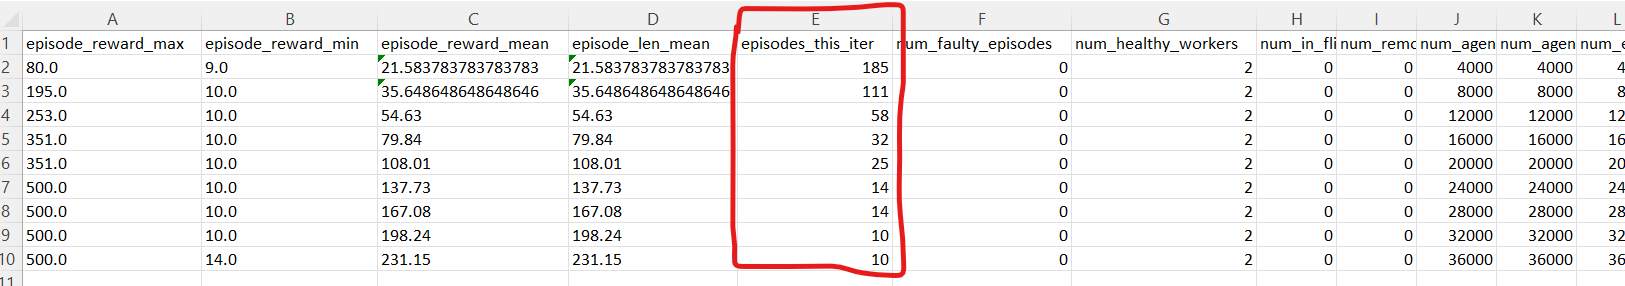


In [9]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/videos/rl-video-episode-125.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Create inference based on best model

Find some links of interest: 


*   Example of using Rllib with tuner: https://docs.ray.io/en/latest/tune/examples/pbt_ppo_example.html#tune-rllib-example
*   Compute actions from a trained agents: https://docs.ray.io/en/latest/rllib/rllib-training.html#computing-actions.





The first step to see how the algorithm operates in inference is to rescue the best model trained.

In [10]:
import os
from ray.rllib.algorithms.algorithm import Algorithm

# Get the best checkpoint
best_result = results.get_best_result()
print(best_result.checkpoint)

# import a model given the path of the checkpoint
loaded_ppo = Algorithm.from_checkpoint(best_result.checkpoint)
loaded_policy = loaded_ppo.get_policy()

2023-04-16 10:15:50,954	WARNING algorithm_config.py:596 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
2023-04-16 10:15:50,968	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


Checkpoint(local_path=/content/results/PPO/PPO_CartPoleMonitor-v1_169d4_00000_0_lr=0.0010_2023-04-16_10-11-44/checkpoint_000008)


2023-04-16 10:16:07,421	INFO trainable.py:172 -- Trainable.setup took 16.455 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-04-16 10:16:07,425	WARNING util.py:67 -- Install gputil for GPU system monitoring.


Since our "custom model" is nothing more than a CartPole with a few commands to record the action in a fancy manner, we will use the original "CartPole-v1" model for inference.

Notice as well that the loop used is longer than the used for the training example. This means that the agent could fail toward the end

In [11]:
episode_reward = 0
terminated = truncated = False

env_name = "CartPole-v1"
env = gymnasium.make(env_name, render_mode='rgb_array')

obs, info = env.reset()
frames = []  # Store frames for creating a video

# while not terminated and not truncated:
for _ in range(1000): # Longer episode than the one that gives a reward of 100
    action, _, _ = loaded_policy.compute_single_action(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    frame = env.render()  # Render the environment as an image
    frames.append(frame)
    episode_reward += reward

env.close()

print(f"Episode reward: {episode_reward}")

/usr/local/lib/python3.9/dist-packages/gymnasium/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Episode reward: 543.0


Find below the video of the inference mode

In [12]:
from IPython.display import HTML
import base64
import imageio

# Create a video from frames
video_name = 'cartpole_training.mp4'
imageio.mimwrite(video_name, frames, fps=30)  # Save the video

# Display the video
video = open(video_name, 'rb').read()
encoded = base64.b64encode(video)

HTML(data='''
    <video width="360" height="auto" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
    </video>'''.format(encoded.decode('ascii')))

## PPO example with custom model

For the sake of this example, the custom model was not thought to be optimized but only with the intention of creating a template of how to create a custom model.

Additionally, here is an example of the creation of a custom model in pytorch: https://github.com/ray-project/ray/blob/master/rllib/examples/custom_rnn_model.py

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.utils.framework import try_import_torch

_, nn = try_import_torch()

class CustomModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)

        # Define your custom neural network architecture here
        self.fc1 = nn.Linear(obs_space.shape[0], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, num_outputs)
        self.value_head = nn.Linear(128, 1)  # Add a separate value head

    def forward(self, input_dict, state, seq_lens):
        x = input_dict["obs"].float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        self._features = F.relu(self.fc3(x))
        logits = self.fc4(self._features)
        return logits, state

    def value_function(self):
        # Implement the value function
        return self.value_head(self._features).squeeze(1)



/usr/local/lib/python3.9/dist-packages/jax/_src/deprecations.py:51: DeprecationWarning: jax.ShapedArray is deprecated. Use jax.core.ShapedArray
  warnings.warn(message, DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


**How is the code obtaining the necessary parameters to build constructor of the custom model?**(CHATGPT answer)

https://docs.ray.io/en/master/rllib/package_ref/doc/ray.rllib.models.torch.torch_modelv2.TorchModelV2.__init__.html#ray.rllib.models.torch.torch_modelv2.TorchModelV2.__init__ Based on this example it seems that it would not be necessary to add them manually, because they would be included when instantiating *args, **kwargs

When you register a custom model builder function with Ray RLlib using ModelCatalog.register_custom_model, RLlib will automatically pass the necessary parameters to the builder function. In the example provided, the custom_model_builder function has the following parameters:


`def custom_model_builder(model_config, action_space, observation_space, num_outputs):`

These parameters are provided by RLlib:

*   **model_config**: A dictionary containing the model configuration from the main RLlib configuration. This is useful when you want to pass additional,parameters to the custom model. 
*   **action_space**: The action space of the environment. This object is an instance of a Gym Space class and describes the possible actions that an agent can take in the environment.
*   **observation_space**: The observation space of the environment. This object is also an instance of a Gym Space class and describes the shape and range of the observations that the agent receives from the environment.
*   **num_outputs**: The number of output units in the final layer of the neural network. This value is derived from the action space and is used to build the output layer of the custom model.

Here, observation_space.shape[0] is the size of the input layer, which corresponds to the size of the observation space. num_outputs is the size of the output layer, which depends on the action space


**Why is necessary the value_function in the custom model? Is there any part of the documentation that may back up this statement?**

In the documentation says that you can overwrite the value function. An example of how to do it can be found in https://docs.ray.io/en/latest/rllib/rllib-models.html#wrapping-a-custom-model-tf-and-pytorch-with-an-lstm-or-attention-net

``` python
class MyCustomModel(TorchModelV2):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super().__init__(obs_space, action_space, num_outputs, model_config, name)
        self.num_outputs = int(np.product(self.obs_space.shape))
        self._last_batch_size = None

    # Implement your own forward logic, whose output will then be sent
    # through an LSTM.
    def forward(self, input_dict, state, seq_lens):
        obs = input_dict["obs_flat"]
        # Store last batch size for value_function output.
        self._last_batch_size = obs.shape[0]
        # Return 2x the obs (and empty states).
        # This will further be sent through an automatically provided
        # LSTM head (b/c we are setting use_lstm=True below).
        return obs * 2.0, []

    def value_function(self):
        return torch.from_numpy(np.zeros(shape=(self._last_batch_size,)))
```




In [2]:
from ray.rllib.models import ModelCatalog

ModelCatalog.register_custom_model("custom_model", CustomModel)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**How many things can you configure in the config file (framework, environment, ...)?? **

In the following link you have a whole list of the configuration methods that can be used (https://docs.ray.io/en/master/rllib/package_ref/algorithm.html)


* callbacks(callbacks_class)
* debugging(*[, logger_creator, ...])
* environment([env, env_config, ...])
* evaluation(*[, evaluation_interval, ...])
* experimental(*[, ...])
* fault_tolerance([recreate_failed_workers, ...])
* framework([framework, eager_tracing, ...])
* training([gamma, lr, train_batch_size, ...])
* ...

Sets the training related configuration.



In [4]:
import ray

# Start up Ray. This must be done before we instantiate any RL agents.
ray.init(num_cpus=3, ignore_reinit_error=True, log_to_driver=False)

2023-04-16 10:21:38,006	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.9.16
Ray version:,2.3.1


In [ ]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray import air
from ray import tune
from ray.tune.registry import register_env
import os

def create_environment(env_config):
    # Specify the video directory
    video_dir = os.path.join(os.getcwd(), "videos")
    if not os.path.exists(video_dir):
        os.makedirs(video_dir)

    # Create the environment and apply the Monitor wrapper
    env = gymnasium.make("CartPole-v1", render_mode='rgb_array')
    env = RecordVideo(env, video_dir)
    return env

# Register the custom environment
register_env("CartPoleMonitor-v1", create_environment)

config = PPOConfig()
# Print out some default values.
print(config.clip_param)  # doctest: +SKIP
# Update the config object.
config.training(  # doctest: +SKIP
lr=tune.grid_search([0.001, 0.0001]), clip_param=0.2)

# Set the config object's env.
config = config.environment(env="CartPoleMonitor-v1")
config = config.framework("torch").training(model={"custom_model": "custom_model"})

# Use to_dict() to get the old-style python config dict
# when running with tune.
tuner = tune.Tuner(  # doctest: +SKIP
     "PPO",
     run_config=air.RunConfig(stop= {"training_iteration": 20, "episode_reward_mean": 200},
                              local_dir="./results"),
     param_space=config.to_dict(),
)

results = tuner.fit()